# Models

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score

### Model for normv(lt, lg)

In [2]:
dfAirScaledMedianStations=pd.read_csv("5_dfAirScaledMedianStations.csv") #generated in dataGeneration notebook
dfAirScaledMedianStations.dtypes

id_amat      int64
valore     float64
normv      float64
name        object
coords      object
lt         float64
lg         float64
dtype: object

In [3]:
dfAirScaledMedianStations

,id_amat,valore,normv,name,coords,lt,lg
0,2,12.0,0.150602,via Pascal *,"[45.4740982055664, 9.23478031158447]",45.474098,9.23478
1,3,2.2,0.281250,viale Liguria,"[45.4441986083984, 9.16944026947021]",45.444199,9.16944
2,4,10.0,0.233645,viale Marche,"[45.4962997436523, 9.19083976745605]",45.496300,9.19084
3,6,14.0,0.200935,via Senato *,"[45.4705009460449, 9.19791984558105]",45.470501,9.19792
4,7,52.0,0.261111,Verziere,"[45.4635009765625, 9.19534015655518]",45.463501,9.19534


In [4]:
pf = PolynomialFeatures(degree=3)
X = pf.fit_transform(dfAirScaledMedianStations[["lt","lg"]])

y = dfAirScaledMedianStations[["normv"]]
normv_lt_lg_LinearRegression = LinearRegression()
normv_lt_lg_LinearRegression.fit(X,y)

print(normv_lt_lg_LinearRegression.coef_)
print(normv_lt_lg_LinearRegression.intercept_)

[[ 1.25489776e-01 -6.91488747e+00  1.41593159e+01 -3.00570831e+02
   2.89897300e+02  1.31052271e+02  4.69930914e+00 -3.96365662e+00
  -1.37872459e+01  1.62454833e+01]]
[163279.21542147]


In [5]:
def predictContamination(lt, lg):
    """
    The function returns contamination values based on location
    Input:
    lt (float): latitude
    lg (float): longitude
    
    Output:
    Scaled contamaination value
    """
    return normv_lt_lg_LinearRegression.predict(pf.fit_transform([np.array([lt,lg])]))[0][0]

#### Saving the model

In [6]:
pkl_filename = "models/normv_lt_lg_LinearRegression.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(normv_lt_lg_LinearRegression, file)

### Model for price([type], lt, lg, totalScore)

In [7]:
dfPredict=pd.read_csv("dfPredict.csv") #generated in dataGeneration notebook
dfPredict.dtypes

Appartamento      int64
Attico            int64
Bilocale          int64
Loft              int64
Mansarda          int64
Monolocale        int64
Open              int64
Quadrilocale      int64
Terratetto        int64
Trilocale         int64
Villa             int64
lt              float64
lg              float64
totalScore      float64
price             int64
dtype: object

In [8]:
dfPredict.sample(5)

,Appartamento,Attico,Bilocale,Loft,Mansarda,Monolocale,Open,Quadrilocale,Terratetto,Trilocale,Villa,lt,lg,totalScore,price
87,0,0,1,0,0,0,0,0,0,0,0,45.440737,9.145208,2.115507,800
291,0,0,1,0,0,0,0,0,0,0,0,45.512982,9.219899,0.840491,700
827,0,0,1,0,0,0,0,0,0,0,0,45.462329,9.175612,1.365648,1450
557,0,0,1,0,0,0,0,0,0,0,0,45.481813,9.164278,2.498004,1800
111,0,0,0,0,0,0,0,0,0,1,0,45.478178,9.132666,2.840327,2165


In [9]:
X_train, X_test, y_train, y_test = train_test_split(dfPredict[dfPredict.columns[:-1]], 
                                                    dfPredict[dfPredict.columns[-1:]], 
                                                    test_size=0.2)


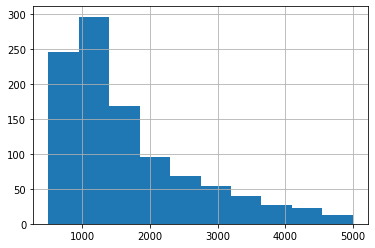

In [10]:
dfPredict["price"].hist()

I used TransformedTargetRegressor with log transformation because price distribution is slightly scewed. After the transofrmation the distribution will look more normal which will lead to a better model.

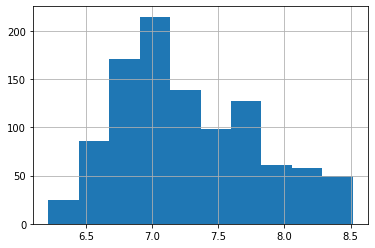

In [11]:
np.log(dfPredict["price"]).hist()

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
price_type_lt_lg_totalScore_RandomForestRegressor = RandomForestRegressor(max_samples=400)
price_type_lt_lg_totalScore_RandomForestRegressor = TransformedTargetRegressor(regressor=RandomForestRegressor(),func=np.log1p,inverse_func=np.expm1)
price_type_lt_lg_totalScore_RandomForestRegressor.fit(X_train,y_train)

TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log1p'>,
                           inverse_func=<ufunc 'expm1'>,
                           regressor=RandomForestRegressor(bootstrap=True,
                                                           ccp_alpha=0.0,
                                                           criterion='mse',
                                                           max_depth=None,
                                                           max_features='auto',
                                                           max_leaf_nodes=None,
                                                           max_samples=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=2,
        

In [13]:
np.mean(-1*cross_val_score(price_type_lt_lg_totalScore_RandomForestRegressor, X_train, y_train, cv =5, scoring='neg_mean_squared_error')) ** 0.5

284.2152541666504

In [14]:
np.mean(-cross_val_score(price_type_lt_lg_totalScore_RandomForestRegressor, X_train, y_train, cv =5, scoring='neg_mean_absolute_error'))

150.979166268861

#### Checking metrics for test data

In [15]:
y_pred = price_type_lt_lg_totalScore_RandomForestRegressor.predict(X_test)

In [16]:
mean_squared_error(y_test, y_pred) ** 0.5

311.26302391902146

In [17]:
mean_absolute_error(y_test, y_pred)

151.396594108486

#### Checking feature importances

In [18]:
from collections import defaultdict

d = defaultdict()
for f, i in zip(X_test.columns,price_type_lt_lg_totalScore_RandomForestRegressor.regressor_.feature_importances_):
    d[f] = i
{k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

{'Terratetto': 0.0,
 'Mansarda': 4.5680193657163415e-05,
 'Open': 0.0001216564414405989,
 'Villa': 0.00030201368360154897,
 'Loft': 0.001275824058530963,
 'Quadrilocale': 0.003749564598682721,
 'Trilocale': 0.004575607450294907,
 'Attico': 0.004697179995120333,
 'Appartamento': 0.008137056313828753,
 'Bilocale': 0.03772357591687659,
 'Monolocale': 0.039647762413844316,
 'lg': 0.10881395256572406,
 'lt': 0.25187154492671976,
 'totalScore': 0.5390385814416784}

#### Saving the model

In [19]:
pkl_filename = "models/price_type_lt_lg_totalScore_RandomForestRegressor.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(price_type_lt_lg_totalScore_RandomForestRegressor, file)

### Model for totalScore(lt, lg)

In [20]:
# Filtering initial data
X_train2 = X_train[["lt","lg"]]
y_train2 = X_train[["totalScore"]]
X_test2 = X_test[["lt","lg"]]
y_test2 = X_test[["totalScore"]]

totalScore_lt_lg_RandomForestRegressor = RandomForestRegressor()
totalScore_lt_lg_RandomForestRegressor.fit(X_train2,y_train2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

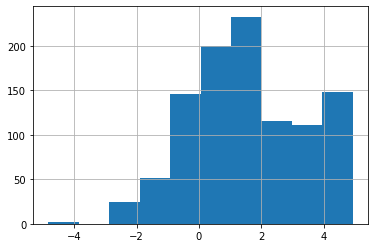

In [21]:
dfPredict["totalScore"].hist()

#### RMSE

In [22]:
np.mean(-1*cross_val_score(totalScore_lt_lg_RandomForestRegressor, X_train2, y_train2.values.ravel(), cv =5, scoring='neg_mean_squared_error')) ** 0.5

0.9698332194816196

#### MAE

In [23]:
np.mean(-cross_val_score(totalScore_lt_lg_RandomForestRegressor, X_train2, y_train2.values.ravel(), cv =5, scoring='neg_mean_absolute_error'))

0.6681766432867808

#### Saving the model

In [24]:
pkl_filename = "models/totalScore_lt_lg_RandomForestRegressor.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(totalScore_lt_lg_RandomForestRegressor, file)